In [4]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
#from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

qiskit_runtime_service.__init__:INFO:2024-03-02 19:01:18,142: Default instance: ibm-q/open/main


In [8]:
# useful additional packages
import matplotlib.pyplot as plt
import numpy as np
import pylab

import networkx as nx

#from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA, COBYLA
#from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler 
from qiskit_optimization.algorithms import MinimumEigenOptimizer

from qiskit_optimization.converters import QuadraticProgramToQubo

from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector

from itertools import permutations #per brutal approches TSP

In [9]:
#draw a graph coloring the nodes 

#funzione per disegnare un grafo con nodi colorati
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
    
#funzione per disegnare un cammino su un grafo 
def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)

### TSP 

distance
 [[ 0. 53. 56. 27. 75.]
 [53.  0.  4. 33. 60.]
 [56.  4.  0. 37. 63.]
 [27. 33. 37.  0. 51.]
 [75. 60. 63. 51.  0.]]


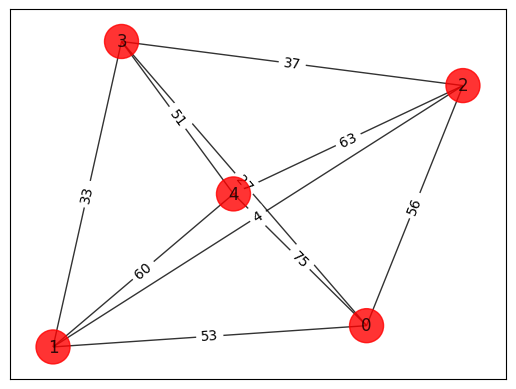

In [10]:
# Generating a specific graph 
n = 5 # num
num_qubits = n**2

G= nx.Graph() # definizione del grafo
G.add_nodes_from(np.arange(0, n, 1)) # aggiungo i vertici 
elist = [(0, 1, 53), (0, 2, 56), (0, 3, 27), (0, 4, 75),
         (1, 2, 4), (1, 3, 33), (1, 4, 60),
         (2, 3, 37), (2, 4, 63),
         (3, 4, 51)] # definisco la lista degli archi [(i,j,peso)]
### tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)# aggiungo gli archi al grafo

tsp=Tsp(G)

# grafico
adj_matrix = nx.to_numpy_array(G)
print("distance\n", adj_matrix)
colors = ["r" for node in G.nodes]
pos = nx.spring_layout(G)
draw_graph(tsp.graph, colors, pos)


In [7]:
## define the ising model

qp = tsp.to_quadratic_program()
qp2qubo= QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()

In [8]:
###EXACT SOLUTION
###Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

print("energy:", result.eigenvalue.real)
print("tsp objective:", result.eigenvalue.real + offset)
x = tsp.sample_most_likely(result.eigenstate)
print("feasible:", qubo.is_feasible(x))
z= tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))

energy: -161634.5
tsp objective: 198.0
feasible: True
solution: [0, 3, 4, 1, 2]
solution objective: 198.0


In [11]:
# create the Ansatz
def W_circuit(QC, n, q1n, theta):
    QC.x(q1n)
    for j in range(q1n+1,q1n+n,1):
        QC.ry(theta[j-1], j)
        QC.cz(j-1,j)
        QC.ry(-theta[j-1], j)
    for j in range(q1n+1,q1n+n,1):
        QC.cx(j,j-1)

def base_circuit(QC, n, theta):
    #theta1 = ParameterVector('theta2', 1)
    QC.x(0)
    QC.ry(theta[1], 1)
    QC.cz(0,1)
    QC.ry(-theta[1], 1)
    QC.cx(1,0)
    QC.cx(1,n)
    QC.cx(0,n+1)


In [12]:
qc = QuantumCircuit(n**2)
theta = ParameterVector('theta', n**2)
base_circuit(qc,n, theta)
for i in range(3,n+1,1):
    W_circuit(qc, i, n*(i-1), theta)
for k in range (3,n+1,1):
    for v in range(1,k,1):
        for p in range(1,k,1):
            qc.cswap(n*(k-1)+v-1,n*(p-1)+n-(n-k)-1,n*(p-1)+v-1)
ansatz=qc
#qc.draw()

In [11]:
counts=[]
params=[]
values=[]
mddict=[]
def store_intermediate_result(count, parameters, value, step):
    counts.append(count)
    params.append(parameters)
    values.append(value)
    mddict.append(step)
  #  nonso.append(nnso)

In [12]:
counts=[]
params=[]
values=[]
mddict=[]
optimizer = COBYLA(maxiter=30) #define the optimizer
vqe= SamplingVQE(sampler=Sampler(), ansatz=ansatz, optimizer=optimizer,callback=store_intermediate_result) #define the SamplingVqe
# run SamplingVQE 
result=vqe.compute_minimum_eigenvalue(qubitOp)


energy: -161629.6135632265
time: 1846.8801577091217
feasible: True
solution: [4, 2, 1, 0, 3]
solution objective: 198.0


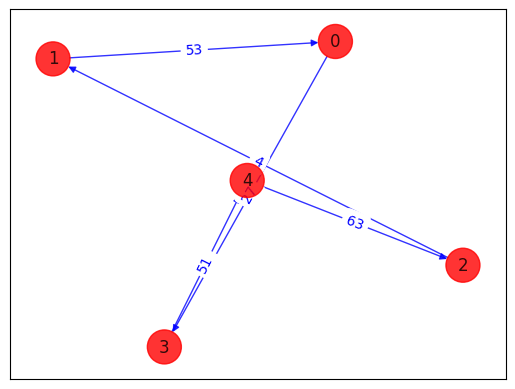

In [13]:
#result

print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
x= tsp.sample_most_likely(result.eigenstate)
print("feasible:", qp.is_feasible(x))
z = tsp.interpret(x) #cammino 
print("solution:", z)
p=tsp.tsp_value(z, adj_matrix) # peso totale del cammino
print("solution objective:", p) 
draw_tsp_solution(tsp.graph, z, colors, pos) #plot della soluzioe


/opt/conda/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


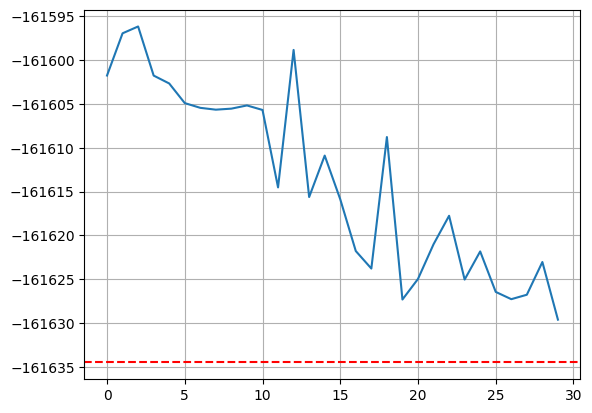

In [14]:
plt.axhline(y=-161634.5, color='r', linestyle='--')

pylab.plot(values)
pylab.grid(True)
# Mostra il grafico
pylab.show()

In [15]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler #solo per eseguire il cicuito in runtime

In [16]:
optimizer = COBYLA(maxiter=20) #define the optimizer
backend=service.backend("ibmq_qasm_simulator") #scegli backend
with Session (backend=backend) as s:
    vqe= SamplingVQE(sampler=Sampler(backend=backend, session=s), ansatz=ansatz, optimizer=optimizer) #define the SamplingVqe
    # run SamplingVQE
    result = vqe.compute_minimum_eigenvalue(qubitOp)
s.close()

base_primitive._run_primitive:INFO:2024-02-24 19:37:44,709: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'job_tags': []}, 'simulator': {}}
base_primitive._run_primitive:INFO:2024-02-24 19:42:13,880: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'job_tags': []}, 'simulator': {}}
base_primitive._run_primitive:INFO:2024-02-24 19:49:16,612: Submitti

energy: -161623.98374999998
time: 6741.474617481232
feasible: True
solution: [4, 1, 2, 0, 3]
solution objective: 198.0


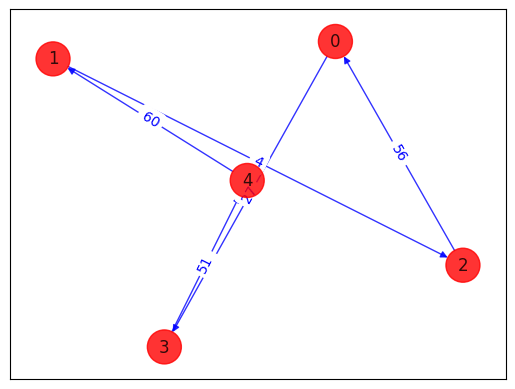

In [17]:
#result

print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
x= tsp.sample_most_likely(result.eigenstate)
print("feasible:", qp.is_feasible(x))
z = tsp.interpret(x) #cammino
print("solution:", z)
p=tsp.tsp_value(z, adj_matrix) # peso totale del cammino
print("solution objective:", p)
draw_tsp_solution(tsp.graph, z, colors, pos) #plot della soluzioe

/opt/conda/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


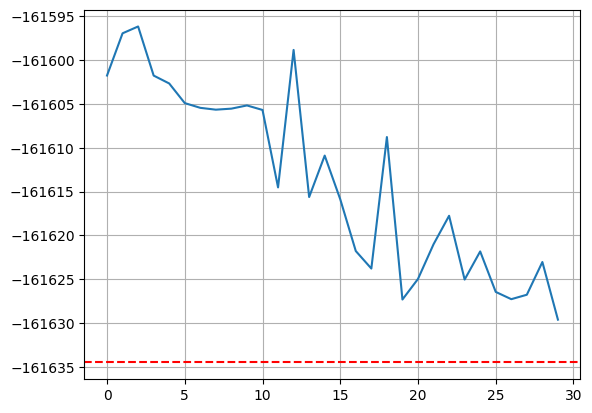

In [18]:
plt.axhline(y=-161634.5, color='r', linestyle='--')

pylab.plot(values)
pylab.grid(True)
# Mostra il grafico
pylab.show()